# Airbnb: IPython Notebook Edition

## 1. Motivation

Our data sets are about Airbnb in Copenhagen from [InsideAirbnb](http://insideairbnb.com/get-the-data.html). We picked the detailed data for **listings**, **calendar**, and **reviews**. The neighbourhood data is also used later for visualizations in Observable.

We chose the Airbnb data set because there are debates and controversies surrounding Airbnb that we will be able to look into. We chose Copenhagen because we can relate Danish news media coverage about Airbnb to the data set.

Our second data set is information regarding hotels in Copenhagen. We made this data set by hand, because a large theme of our project is about Airbnb's unfair competition against the hotel industry.

The user should at the end be able to look into the data sets themselves and arrive at their own conclusions. Having spent more time with these issues ourselves, we intend to highlight our most interesting finds within the visualization.

## 2. Basic stats

It was not necessary to clean the data. However, we do exclude irrelevant columns early on when exploring specific parts of the data. With two of our data sets, namely **calendar** and **reviews**, we found that each listing had many rows dedicated to it. For example, in the calendar, the first listing would have 365 rows, corresponding to a day every year. In those cases, we condense the data such that we get information per listing, which makes it easier to compare listings side-by-side. Equally for reviews, each listing has as many rows as it has reviews, so we format for reviews per listing, and reviews per reviewer.

Once the data is formatted such that each row is one listing/reviewer, it is fairly easy to find distributions from columns. Most of our explorative analysis is about these distributions, and they do confirm some claims from the discussion regarding Airbnb.

For example, by visualizing a distribution of each listing's availability, we find that the majority of listings are only available for short periods of time - as it should be. But the next largest group of listings are available all year round, close to 365 days a year. The smallest group were in between 100-300 days of availability range. The problem is then that houses in Copenhagen are used for rent-outs to tourists rather than citizens living there.

Another claim we verified is that some hosts own multiple listings and rent those out. In the most extreme case, one host owns about 250 listings all over Copenhagen. Needless to say, this is more convenient than just owning hotel in Copenhagen - and perhaps just as lucrative.

## 3. Data Analysis

### 3.1 Earnings
The first topic we looked into were earnings. [One article](https://www.avisen.dk/scorer-kassen-paa-at-leje-ud-igennem-airbnb-gaar-den_395096.aspx) (2016) claims that it is more lucrative to rent out an available room through Airbnb than to just rent out to Danish citizens for long-term living, so naturally we were interested to see how much hosts were earning.

Given that price and availability was included in the data set, it seemed trivial to calculate earnings. However, that turned out not to be case, because price and availability says nothing about actual use. Now, reviews are an indicator of use, but not a metric.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
listings = pd.read_csv("listings.csv", low_memory=False)

Many countries and cities have [started regulating](https://www.dr.dk/nyheder/udland/du-faar-nye-airbnb-regler-saadan-goer-de-i-resten-af-europa) how much private renting is allowed. In Denmark, if the renting platform (Airbnb) is collaborating with the Danish tax system, a customer may rent out by default 70 days a year.

This is why our upper limit for availability is 70 days, whenever it is used for calculations.

We also need to convert the prices to integers. Despite having a dollar sign, the numbers are in Danish crowns (DKK). We checked this by comparing the data set's price values with the webpages of listings.

In [21]:
# Convert prices into integer format.
def priceToInt(x):
    s = x[1:-3]
    if (len(s) > 3):
        l = len(s) - 3 - 1
        s = s[:l] + s[(l + 1):]
    return int(s)

listings['price'] = listings['price'].apply(lambda x: priceToInt(x))

In [37]:
potential_maximum_earnings = []

for i in range(0,listings.count()[0]):
    a = listings.availability_365[i]
    if (a > 70):
        a = 70
    price = listings.price[i]
    potential_maximum_earnings.append(a * price)
    
# Add as new column.
listings['potential_maximum_earnings'] = pd.Series(potential_maximum_earnings, index=listings.index)

Text(0.5, 0.98, 'Distribution of prices per day')

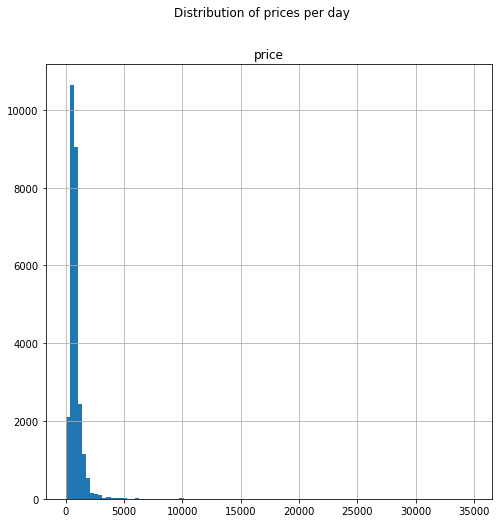

In [47]:
listings.hist(column="price", bins=100, figsize=(8,8))
plt.suptitle("Distribution of prices per day")

Text(0.5, 0.98, 'Distribution of maximum potential earnings')

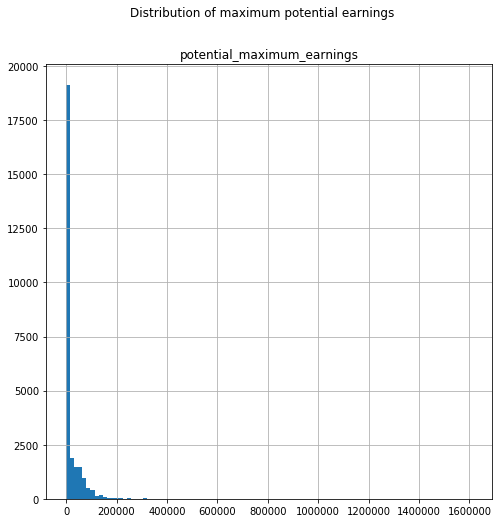

In [44]:
listings.hist(column="potential_maximum_earnings", bins=100, figsize=(8,8))
plt.suptitle("Distribution of maximum potential earnings")

Text(0.5, 0.98, 'Distribution of maximum potential earnings over 100k')

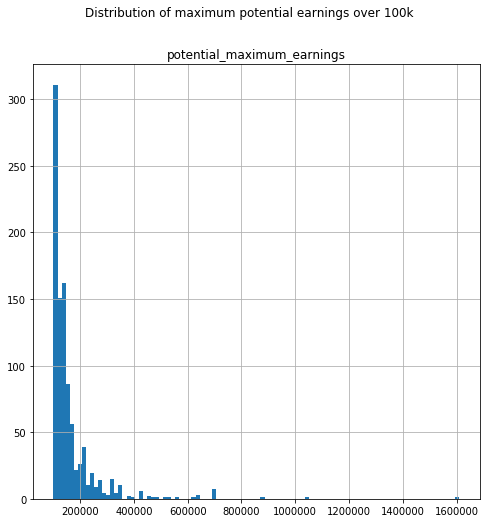

In [46]:
listings[listings.potential_maximum_earnings > 100000].hist(column="potential_maximum_earnings", bins=100, figsize=(8,8))
plt.suptitle("Distribution of maximum potential earnings over 100k")

The given price is per day. Consider that a host rents out the maximum number of days they possibly can (capped at 70 days) at the price listed - we call this value *potential maximum earnings*. This is the highest amount of money that any host can possibly earn.

The problem with this calculation is that it ignores how much a listing is actually put to use. We have reviews as an indicator of use, but that is not an accurate metric. As an example of this problem, let us look into the listing that can earn about 1.6 million DKK a year.

In [65]:
listings.potential_maximum_earnings.describe()

count    2.646100e+04
mean     1.832545e+04
std      4.124213e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.193400e+04
max      1.610140e+06
Name: potential_maximum_earnings, dtype: float64

In [66]:
for i in range(0,listings.count()[0]):
    if listings.potential_maximum_earnings[i] > 1610000:
        print(i)

20470


In [67]:
listings[20470:20471].number_of_reviews

20470    0
Name: number_of_reviews, dtype: int64

In [87]:
listings[20470:20471].listing_url

20470    https://www.airbnb.com/rooms/24426917
Name: listing_url, dtype: object

As we can see, the highest potential earner can earn 1.6 million DKK a year if the room is rented out as much as possible, but by looking into this listing specifically, we found that it contained no reviews. It is possible that it has never been put to use on Airbnb's service.

It turns out this is not simply a "room." You may click the link and see that it is listed as "Private luxury 'floating hotel' at quay in Cph", and indeed, the pictures show it. No wonder the price - and that nobody seems to have reviewed it.

This is the core of the problem with measuring maximum potential earnings - it tells us nothing about how much hosts are earning in practice.

Using reviews per month as an indicator (but not a metric) of "general popularity", can we use that as a means to filter out unused listings? We shall try with a scatter plot with potential maximum earnings/reviews per month.

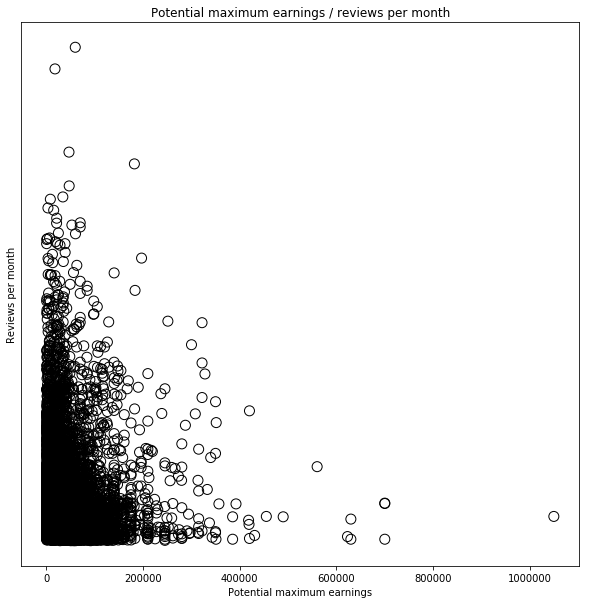

In [68]:
x = listings[listings.potential_maximum_earnings > 0]['potential_maximum_earnings']
y = listings[listings.potential_maximum_earnings > 0]['reviews_per_month']

plt.figure(figsize=(10,10))
plt.scatter(x, y, s=100, facecolors='none', edgecolors='k')
plt.title("Potential maximum earnings / reviews per month")
plt.yticks([],[])
plt.xlabel("Potential maximum earnings")
plt.ylabel("Reviews per month")

plt.show()

We filtered out listings that are unavailable. On the X-axis, we have the maximum potential earnings, and on the Y-axis, we have reviews per month.

A listing that has reviews (and somewhat regularly) is likely to be closer to reach their maximum potential earnings. Still, a listing with many reviews does not necessarily mean a listing is rented out for more days; One issue here is that somebody can book a listing for a few weeks and only leave behind one review, while another guest can book for only one night and also do a review. The reviews says nothing about the number of days a guest has stayed the night.

It all boils down to a fundamental problem; Our data says nothing about how many days listings were actually booked. We can only estimate which listings are top earners.

Simplifying the problem a bit, we can do another scatter plot of price/reviews per month:

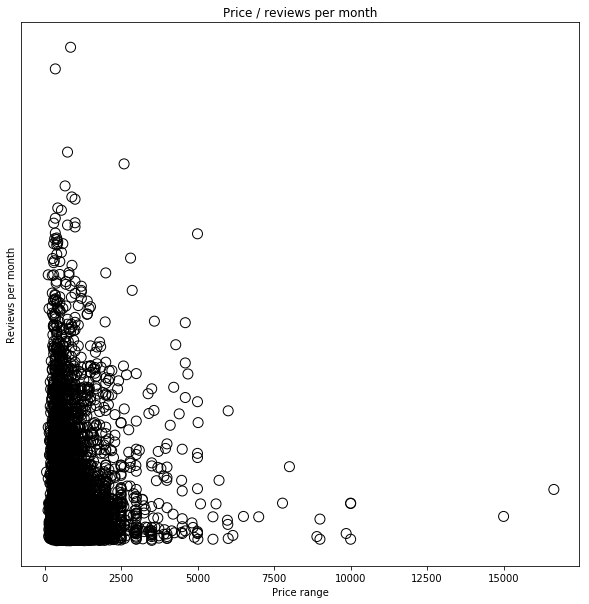

In [70]:
x = listings[listings.potential_maximum_earnings > 0]['price']
y = listings[listings.potential_maximum_earnings > 0]['reviews_per_month']

plt.figure(figsize=(10,10))
plt.scatter(x, y, s=100, facecolors='none', edgecolors='k')
plt.title("Price / reviews per month")
plt.yticks([],[])
plt.xlabel("Price range")
plt.ylabel("Reviews per month")

plt.show()

Listings that have many reviews are likely put to lots of use, while price implies earnings. So being closer to the top right means a listing is both being put to use at a high price. Unsurprisingly, we find that the vast majority listings are clustered in the bottom left, with low prices and a low frequency of reviews. We do see some listings at the 5000 DKK/night price range with a decent frequency of reviews, and these listings are likely to earn well through Airbnb.

Here is an idea: If we use the reviews per month as an indicator of popularity and multiply that with price, we get a "score" for a given listing. We can get another "score" by multiplying prices with total number of reviews, and put both scores into a scatter plot.

We can certainly do a scatter plot with just reviews per month versus total number of reviews, but this leaves out the pricing, which is crucial. By multiplying prices into both metrics, we can filter out listings that have low prices and still plot two columns that are not prices.

In [71]:
score1 = []
score2 = []

for i in range(0,listings.count()[0]):
    price = listings.price[i]
    score1.append(price * listings.reviews_per_month[i])
    score2.append(price * listings.number_of_reviews[i])

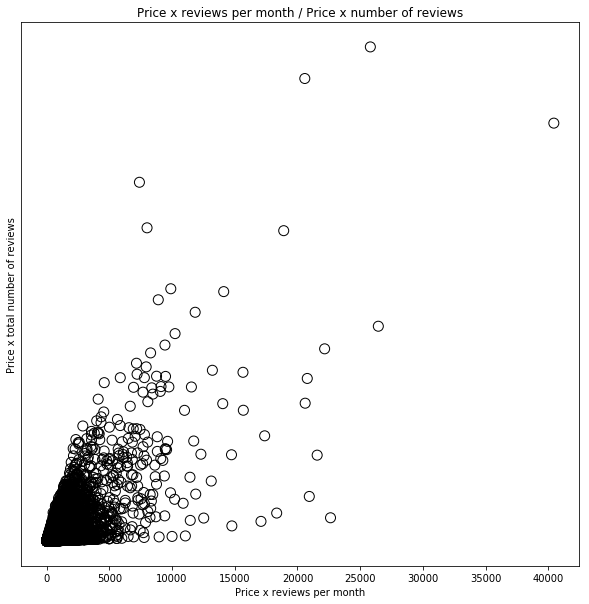

In [72]:
plt.figure(figsize=(10,10))
plt.scatter(score1, score2, s=100, facecolors='none', edgecolors='k')
plt.title("Price x reviews per month / Price x number of reviews")
plt.yticks([],[])
plt.xlabel("Price x reviews per month")
plt.ylabel("Price x total number of reviews")

plt.show()

Ignore the actual numbers on both the X-axis and the Y-axis and just consider the visualization. The cluster at the bottom left are listings that are in no way the big winners on the Airbnb service, with too low prices and too few reviews

Interestingly, if a listing has a high frequency of reviews, that can compensate for a low price - and equally, a good price can compensate for a middling frequency of reviews.

On the X axis, we find listings with good frequencies of reviews and good prices, while on the Y axis we find listings with good total number of reviews and good prices.  Listings on the top left have a high number of total reviews, likely indicating that they have been available on the Airbnb services for years, while listings on the lower right are fairly new on the Airbnb platform, but are put to lots of use. Finally, the big winners are on the top right, with a good mix of frequent use, longevity on the platform, and pricing. There is a very clear top three here, so let us look them up.

In [75]:
scoreDeux = pd.Series(score2)
scoreDeux.describe()

count    2.646100e+04
mean     1.052029e+04
std      2.704784e+04
min      0.000000e+00
25%      7.980000e+02
50%      3.348000e+03
75%      1.024000e+04
max      1.057793e+06
dtype: float64

In [82]:
for i in range(0,scoreDeux.count()):
    if scoreDeux[i] > 800000:
        print(i)

3913
7445
15901


In [86]:
listings[3913:3914].listing_url

3913    https://www.airbnb.com/rooms/5275789
Name: listing_url, dtype: object

In [89]:
listings[7445:7446].listing_url

7445    https://www.airbnb.com/rooms/9008858
Name: listing_url, dtype: object

In [88]:
listings[15901:15902].listing_url

15901    https://www.airbnb.com/rooms/19370319
Name: listing_url, dtype: object

As you can see on their pages, these places are located in the center of Copenhagen, have fairly high prices, many reviews and at a good frequency rate. Needless to say, these are prime examples of listings that must be lucrative compared to other listings on the service.

Even though we managed to pinpoint some listings that likely earn well, we will never find the actual earnings with the current data set. These previous pages reveal that you can travel in groups, and that the price may change depending on the number of guests. We do not have the numbers for the past bookings, so the search for earnings ends here.

### 3.2 Availability

One complaint against the Airbnb service is that listings are available for long periods of time, the implication being that houses in big cities are not put to use for living, but for renting.

Text(0.5, 0.98, 'Availability (days per year)')

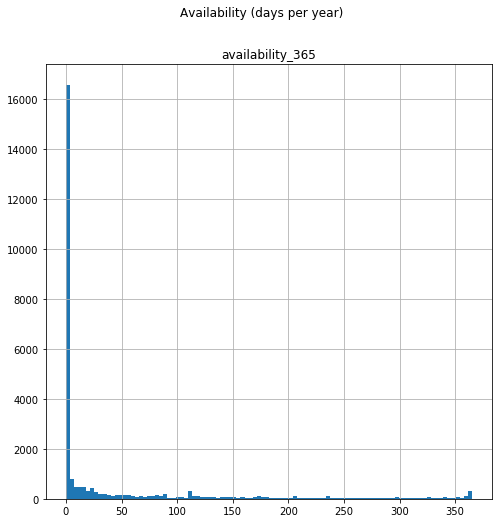

In [92]:
listings.hist(column="availability_365", bins=100, figsize=(8,8))
plt.suptitle("Availability (days per year)")

Text(0.5, 0.98, 'Availability (days per year)')

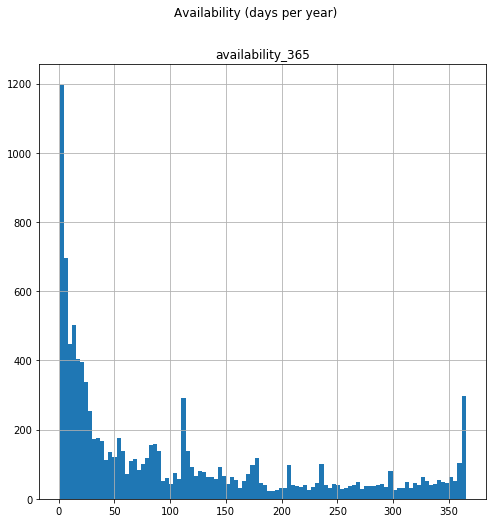

In [96]:
listings[listings.availability_365 > 0].hist(column="availability_365", bins=100, figsize=(8,8))
plt.suptitle("Availability (days per year)")

The first histogram shows that the vast majority of listings in the data set are no longer available for booking as of February 2018, which is the date the data set is from. The second histogram excludes those unavailable listings.

A majority only rents out less than 50 days a year, which is reasonable given how the service is intended to be used. A good amount also keep their calendars more flexible, keeping their bookings available for more than just the maximum of 70 days as per Danish law.

But some listings are available for most of the year, with some listings are available for bookings every day of the year. Does that imply that the host is just always home, always available and happens to be accommodating to guests through Airbnb, or that they do not even live there and simply rent out places without being present at all?

Secondly, if a listing is available for much more than 70 days a year, but you may rent out listings for only a maximum of 70 days a year, then are these rooms/houses/apartments even put to use? Copenhagen is a very dense city - and some of the homes may be empty for large portions of the year.

The distribution is alarming, but we cannot infer anything about these listings from the visualization alone. Remember that availability is not the same as bookings, or how much a listing is put to use. A listing's yearly availability says nothing about the host either - the quality of their hositng, their listing, whether they are even present or absent.

So the question is, can we use reviews as an indicator of use and compare with availability?

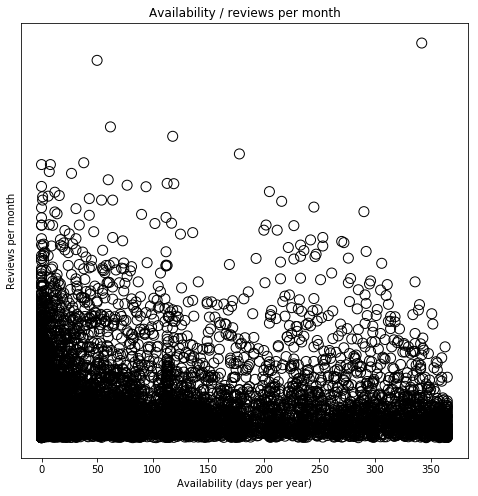

In [98]:
# Let's do another scatter plot, with availability/reviews per month.
x = listings['availability_365']
y = listings['reviews_per_month']

plt.figure(figsize=(8,8))
plt.scatter(x, y, s=100, facecolors='none', edgecolors='k')
plt.title("Availability / reviews per month")
plt.yticks([],[])
plt.xlabel("Availability (days per year)")
plt.ylabel("Reviews per month")

plt.show()

A guess could have been that more availability meant a higher likelyhood and frequency of customers, and therefore also reviews, but we see this is not the case.

The scatter plot is very similar to the distribution of availability (the histogram just before this scatter plot). That means that frequency of reviews (and likely use) does not at all correlate with availability. Listings gets reviews regardless of their yearly availability, or in other words, which places are booked by customers does not seem to depend on their yearly availability, at least statistically.

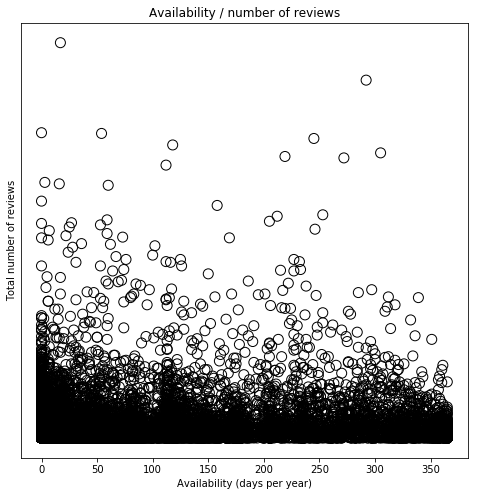

In [102]:
x = listings['availability_365']
y = listings['number_of_reviews']

plt.figure(figsize=(8,8))
plt.scatter(x, y, s=100, facecolors='none', edgecolors='k')
plt.title("Availability / number of reviews")
plt.yticks([],[])
plt.xlabel("Availability (days per year)")
plt.ylabel("Total number of reviews")

plt.show()

We can do a similar scatter plot with total number of reviews and availability, but it supports the same conclusion. Not surprising, since this is also reviews versus availability, but just a different metric for reviews.

### 3.3 Hosts

When multiple listings are owned by the same host, they are known as *multi-listings*.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001102FFDC7B8>]],
      dtype=object)

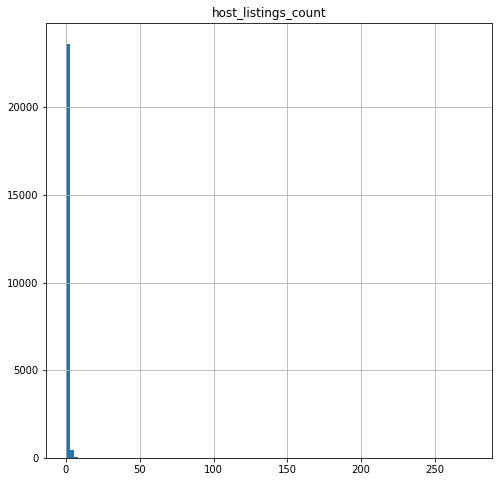

In [4]:
df = listings.drop_duplicates("host_id")
df.hist(column="host_listings_count", bins=100, figsize=(8,8))

Unsurprisingly, the vast majority of hosts only own one place to rent out. But since the X axis stretches to 250, we know that something is off about this distribution.

Let's drop the hosts that own one listing and look at the hosts that own multiple until we can see the distribution more clearly.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001103966B400>]],
      dtype=object)

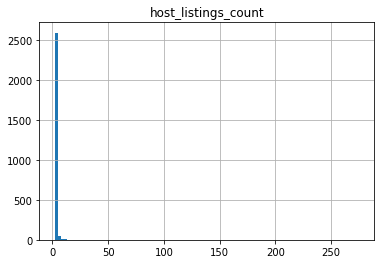

In [8]:
df[df.host_listings_count > 1].hist(column="host_listings_count", bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000110398B2080>]],
      dtype=object)

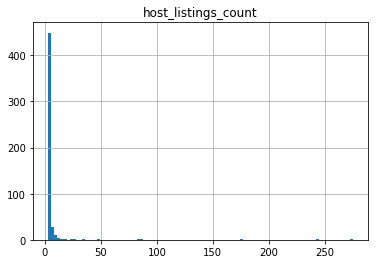

In [9]:
df[df.host_listings_count > 2].hist(column="host_listings_count", bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000110395E0F60>]],
      dtype=object)

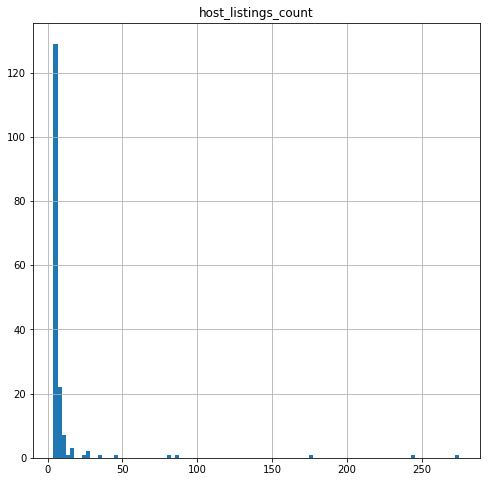

In [7]:
df[df.host_listings_count > 3].hist(column="host_listings_count", bins=100)

The point of showing these multiple visualizations is that the vast majority of hosts only own one place. Exclude those from the histogram, and the vast majority owns two places, then three places, et cetera. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000011039965358>]],
      dtype=object)

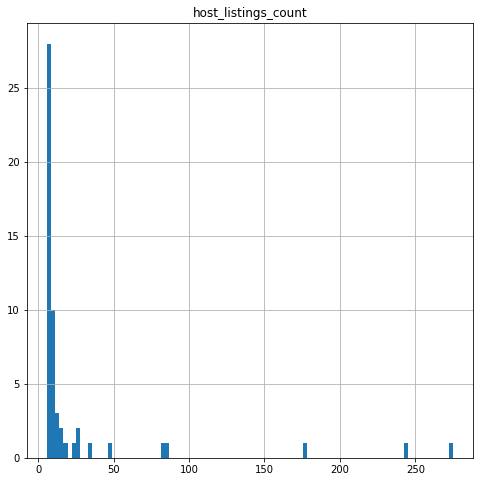

In [12]:
df[df.host_listings_count > 5].hist(column="host_listings_count", bins=100, figsize=(8,8))

Now we can clearly see that there are cases of hosts that own many listings - in the ranges of hundreds.

Let us find their profiles:

In [14]:
df[df.host_listings_count > 150].host_id

19973      3326097
20709    187610263
21592      2770598
Name: host_id, dtype: int64

The [first profile is Ira](https://www.airbnb.com/users/show/3326097), a Swiss man who apparently speaks 8 languages and has 179 listings all over Europe, many of which are luxury flats. Looking into his profile and his listings, we find a logo with [*Smiling Flats*](http://smilingflats.com/), which is the real company behind all these listings. 

The [second profile](https://www.airbnb.com/users/show/187610263) belongs to [*Apartment in Copenhagen*](https://www.apartmentincopenhagen.com/). They did not bother obscuring anything.

The [third profile](https://www.airbnb.com/users/show/2770598) is Moriya, a Swiss woman who apparently speaks 6 languages and has 255 listings also all over Europe. Checking their profile shows a logo of [*Smiling House*](http://smilinghouse.ch/), which should ring a bell.

These are the top examples, but we can of course go even further into the rabbit hole. The point is that companies who cannot compete with Airbnb through their own websites simply join Airbnb and stay on their platform with their hundreds of available listings. Smiling House and Flats are basically the same company, so we can even add up those listings to the same "host", and it is 434 listings in total - but these are multiple cities of Europe, and not only just Copenhagen.

It is fairly obvious that Airbnb is doing nothing, because the *Smiling House* and *Smiling Flats* profiles have been on Airbnb since 2012 and still going strong even to this day. *Apartments in Copenhagen* have been on the platform since 2018, so fairly recent. Regardless, this is really good business for both Airbnb and these companies, so no wonder Airbnb takes no action, even though these companies competes with regular Airbnb customers who do honest rent-outs and use the platform as intended.

Why is this unfair competition against the hotel industry? Because this way, a company can spread out their rents across all of Copenhagen city, while hotels keep all their rooms within buildings in a single area. Secondly, if a hotel room gets a bad review, it affects the reputation of the entire hotel. If a multi-listed room on Airbnb gets a bad reputation, the remaining ratings of other listings by the same host are unaffected.

### 3.4 Reviews: Info per listing

At this point, we dive into the data set containing reviews. The listings data set does contain the date for the latest review, but this data set contains dates for all reviews. This means we can find the first and latest review of a listing and find a range of activity.

In [2]:
# Here's what it looks like
reviews = pd.read_csv("reviews.csv")
reviews.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,6983,8985,2009-09-04,31133,Jeff,"Convenient location, clean apartment, great br..."
1,6983,9199,2009-09-07,11472,Andrea,We really enjoyed staying to Simon in our firs...
2,6983,11763,2009-09-28,35317,Jeanine,"Friendly host, save neighbourhood, clean appar..."


As you can see from the listing ID, this is the same listing that has reviews. Each row is a review, but we are interested in what information we can get per listing.

In [3]:
# Get a series of all listing IDs
listing_ids = reviews['listing_id'].drop_duplicates().reset_index(drop = True)

In [4]:
# Remove months and days from dates and keep only years.
reviews['date'] = reviews['date'].apply(lambda x: int(x[0:4]))

# Create a new data frame with info per listing.
df = reviews.loc[:,['listing_id','date']]

count = []
earliestYear = []
latestYear = []

for i in range(0,listing_ids.count()):
    r = df[df.listing_id == listing_ids[i]]
    count.append(r.count()[0])
    earliestYear.append(r.date.min())
    latestYear.append(r.date.max())
    
info_per_reviewed_listings = pd.DataFrame({'listing_id': listing_ids,
                                           'review_count': count,
                                           'earliestYear': earliestYear,
                                           'latestYear': latestYear})

In [5]:
info_per_reviewed_listings.head(3)

,listing_id,review_count,earliestYear,latestYear
0,6983,167,2009,2019
1,26057,44,2013,2019
2,26473,248,2010,2019


Right now, we have a range of years from the beginning of their activity to their latest activity. Now, let us try to calculate reviews per year, similar to reviews per month from listings data. We already can sort the listings per total reviews, so now we can look into the frequency of reviews, i.e. reviews per year.

In [5]:
freq = []
for i in range(0,listing_ids.count()):
    ## We need to plus by 1 to avoid division by zero,
    ## and also because both first and last year are inclusive.
    d = 1 + info_per_reviewed_listings.iloc[i,3] - info_per_reviewed_listings.iloc[i,2]
    freq.append(info_per_reviewed_listings.iloc[i,1] / d)

In [6]:
info_per_reviewed_listings['reviews_per_year'] = pd.Series(freq, index=listing_ids.index)
info_per_reviewed_listings.head(3)

,listing_id,review_count,earliestYear,latestYear,reviews_per_year
0,6983,167,2009,2019,15.181818
1,26057,44,2013,2019,6.285714
2,26473,248,2010,2019,24.800000


With total number of reviews and their frequency, we can do fundamental distributions and a scatter plot with both variables.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CDDB0397F0>]],
      dtype=object)

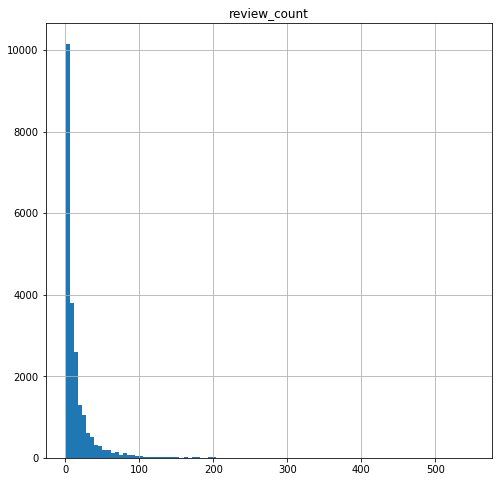

In [8]:
info_per_reviewed_listings.hist(column='review_count', bins=100,figsize=(8,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CDDD7DBCC0>]],
      dtype=object)

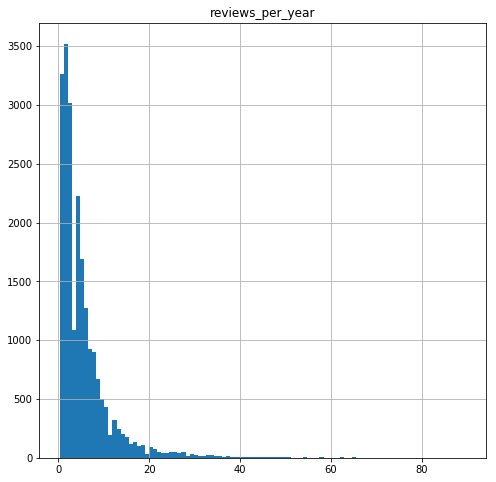

In [9]:
info_per_reviewed_listings.hist(column='reviews_per_year', bins=100,figsize=(8,8))

Unsurprisingly, the vast majority of listings get very few reviews, and therefore the frequency of reviews is also low.

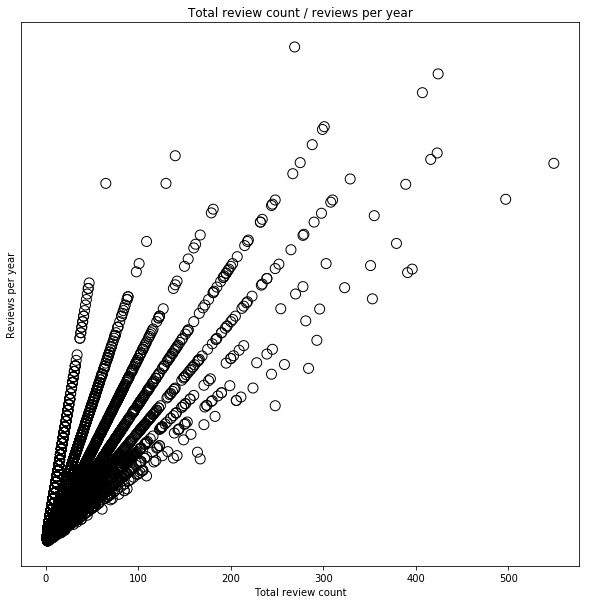

In [10]:
x = info_per_reviewed_listings['review_count']
y = info_per_reviewed_listings['reviews_per_year']

plt.figure(figsize=(10,10))
plt.scatter(x, y, s=100, facecolors='none', edgecolors='k')
plt.title("Total review count / reviews per year")
plt.yticks([],[])
plt.xlabel("Total review count")
plt.ylabel("Reviews per year")

plt.show()

Points on the mid-lower right are listings with many total reviews, but are reviewed fairly infrequently (i.e., the long-runners). Points on the upper left corner are the newest listings with many reviews coming in frequently, but they have few reviews in total comparatively because they have only been active for a single year.

What is immediately eye-catching is that all plot points are results of linear regression. Count all the lines and we find there a total of 10 linear regressions (the flattest ones to the lower right are admittedly faint though).

Each linear regression represents how many years a listing has been active. This makes sense, as reviews span from 2009 to 2019, a total of 11 years inclusive. However, there are only 4 reviews from 2009, so it may as well be 10 years only in practice.

Think about it this way: Listings at the top left have a high review frequency, but low total number of reviews. In other words, the steepest lienar regression shows listings that have only been active for a single year. Equally, the flattest linear regressions are barely visible, because very few listings have been on Airbnb from the start in 2009 and 2010 and are still going strong into 2019, so over a decade.

The linear regression happens because each listing can only be active in whole numbers from 1 to 11. So with these categories in mind, we can do a bar chart of longevity.

In [7]:
longevity = []
for i in range(0,listing_ids.count()):
    longevity.append(1 + info_per_reviewed_listings.latestYear[i] - info_per_reviewed_listings.earliestYear[i])

info_per_reviewed_listings['longevity'] = pd.Series(longevity, index=info_per_reviewed_listings.index)

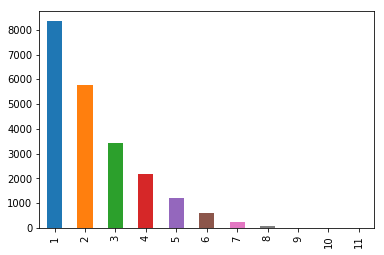

In [18]:
info_per_reviewed_listings.longevity.value_counts().plot.bar()

Unsurprisingly, the longevity of listings is skewed towards a single year of activity. What may be surprising is that there exist thousands of listings that have been on Airbnb for multiple years. This does not necessarily mean that a listing has been available for every year, but rather that its earliest review and its latest review are a set number of years apart.

### 3.5 Info per reviewer

The process is very similar. Since reviewers each have their own unique IDs, can we collect the data and find anything interesting about reviewers? Usually, we can look to the extremes - in this case, the top reviewers of Copenhagen - and see why the leave so many reviews here.

In [14]:
# Get all reviewer IDs
reviewer_ids = reviews['reviewer_id'].drop_duplicates().reset_index(drop = True)

In [15]:
df = reviews.loc[:,['reviewer_id','date']]

In [16]:
count = []
earliestYear = []
latestYear = []

for i in range(0,reviewer_ids.count()):
    r = df[df.reviewer_id == reviewer_ids[i]]
    count.append(r.count()[0])
    earliestYear.append(r.date.min())
    latestYear.append(r.date.max())

In [20]:
reviewers_info = pd.DataFrame({'reviewer_id': reviewer_ids,
                               'reviews_done': count,
                               'earliestYear': earliestYear,
                               'latestYear': latestYear})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000240A50FB668>]],
      dtype=object)

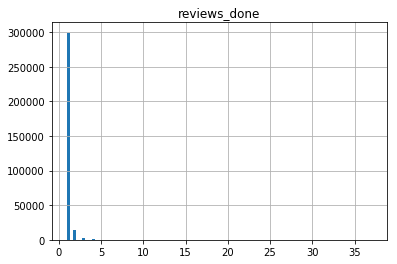

In [22]:
reviewers_info.hist(column='reviews_done', bins=100,)

Needless to say, the vast majority of reviewers only visited Copenhagen once. What are the percentages?

In [26]:
reviewers_info.reviews_done.value_counts()

1     299314
2      14536
3       2055
4        619
5        221
6        131
7         57
8         45
9         35
10        19
11        13
12        12
13         9
14         7
17         3
18         3
19         2
24         2
26         1
15         1
16         1
23         1
25         1
37         1
Name: reviews_done, dtype: int64

In [27]:
297124 / reviewers_info.count()[0] * 100

93.70366048648802

So, less than 6% did two reviews on Copenhagen listings. So what is the distribution for those that left more than 5 reviews?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000240B1EBE0B8>]],
      dtype=object)

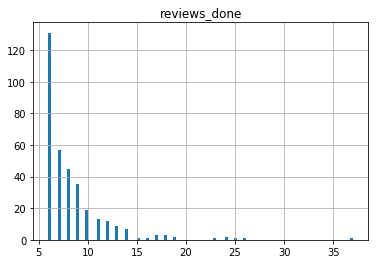

In [28]:
# And what's the distribution for those than left more than 5 reviews?
reviewers_info[reviewers_info.reviews_done > 5].hist(column='reviews_done', bins=100)

In [29]:
reviewers_info.sort_values('reviews_done').tail(10)

,reviewer_id,reviews_done,earliestYear,latestYear
64816,144045819,18,2017,2019
31468,16412829,18,2016,2019
23411,11604068,19,2016,2018
47843,6604623,19,2017,2019
14259,36254879,23,2016,2019
31248,44061416,24,2015,2017
92452,114780841,24,2017,2019
60821,3356928,25,2014,2019
199,4025202,26,2017,2019
11923,47082496,37,2015,2019


By copying and pasting the reviewer IDs into the proper Airbnb url, we can look up their profiles. We can also look into what the data set has to say about them.

Let us look into the person who left behind 37 reviews.

In [30]:
reviews[reviews.reviewer_id == 47082496]

,listing_id,id,date,reviewer_id,reviewer_name,comments
12085,537471,289916084,2018,47082496,Thomas,Truly great beds. Very central. Fast communica...
51873,2200398,132341128,2017,47082496,Thomas,Super communication and service\nminded host. ...
52309,2218946,412275466,2019,47082496,Thomas,Very nice place. Very central. Good bed. What’...
101078,5019399,51683661,2015,47082496,Thomas,"I only stayed for one night, and I even though..."
101095,5019399,68942097,2016,47082496,Thomas,This is the second time I stayed with Jens Jak...
101105,5019399,74087614,2016,47082496,Thomas,Third time I stayed here. That kind of says it...
101116,5019399,79083930,2016,47082496,Thomas,A pleasure as always.
101135,5019399,98896107,2016,47082496,Thomas,As always Jens Jakob is a great host.
101149,5019399,104707011,2016,47082496,Thomas,Super. I stay here everytime I'm in Copenhagen.
101159,5019399,110417230,2016,47082496,Thomas,Stayed there many times. Jakob is a super host.


Turns out [Thomas](https://www.airbnb.com/users/show/47082496) does visit Copenhagen a lot, but he has reviewed the same listing 27 times. Perhaps the Airbnb service demands he reviews the place every time he visits - similar to Ûber. And as always, the reviews do get shorter when one is forced to review the same place over and over and over again.

In [31]:
reviews[reviews.reviewer_id == 36254879]

,listing_id,id,date,reviewer_id,reviewer_name,comments
14463,623404,162750531,2017,36254879,Asma,I ha a great stay at Irismar's place. The room...
14471,623404,188920156,2017,36254879,Asma,"It was my second time at Irismar place, and I ..."
14475,623404,200633943,2017,36254879,Asma,Irismar is a fantastic and very nice host:) It...
14477,623404,214229055,2017,36254879,Asma,Irismar is the best host ever :) the apartment...
14478,623404,228858860,2018,36254879,Asma,Irismar is a great host:) everything was perfe...
14480,623404,232215082,2018,36254879,Asma,I enjoyed my stay at Irismar's place. Very nic...
14481,623404,234273605,2018,36254879,Asma,"Superbe adresse:) L'appartement est genial, et..."
14483,623404,239837800,2018,36254879,Asma,C'est toujours un plaisir de loger chez Irisma...
14484,623404,243239094,2018,36254879,Asma,Merci Irismar pour ton hospitalité. Je recomma...
14487,623404,250784839,2018,36254879,Asma,Simply perfect :) I highly recommend


A bit more variety, but [Asma](https://www.airbnb.com/users/show/36254879) has certainly gone to the same listings in Copenhagen multiple times.

Even though we have only looked at two of the top reviewers of listings in Copenhagen, those that leave behind many reviews do visit the same place over and over again.

Do remember that these are the exceptions rather than the rule, as only 6% leave behind two reviews of Copenhagen listings.

### 3.6 Distribution of reviews over time

We have yet to establish anything about Airbnb's growth. We have used reviews before to indicate use, so it makes sense to do so over all reviews.

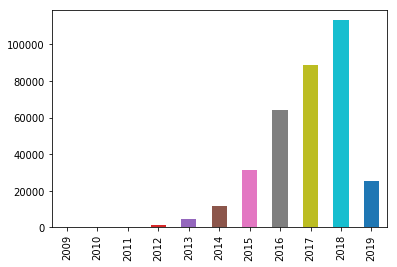

In [35]:
reviews.date.value_counts().sort_index().plot.bar()

This shows the yearly development of Airbnb very clearly. It looks like Airbnb's business in Copenhagen doubled each year until 2016.

As of today's writing in May 2019, the low value for 2019 is because 1) the year not yet over, and 2) our data covers up until 17th of February 2019, so 1½ months.

January/February are probably not high season, but if we make a distribution of January's year-to-year development, then perhaps we can compare the growth?

In [39]:
reviews = pd.read_csv("reviews.csv")
yearMonths = reviews['date'].apply(lambda x: x[0:7])

In [40]:
l = []
for i in range (0, yearMonths.count()):
    if (yearMonths[i][5:7] == '01'):
        l.append(int(yearMonths[i][0:4]))

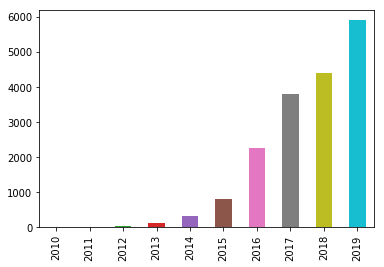

In [41]:
l = pd.Series(l)
l.value_counts().sort_index().plot.bar()

Looks like 2019 is gonna be another great year for Airbnb in Copenhagen, as the growth is not slowing down.

Speaking of which, let us look into the monthly distribution of reviews.

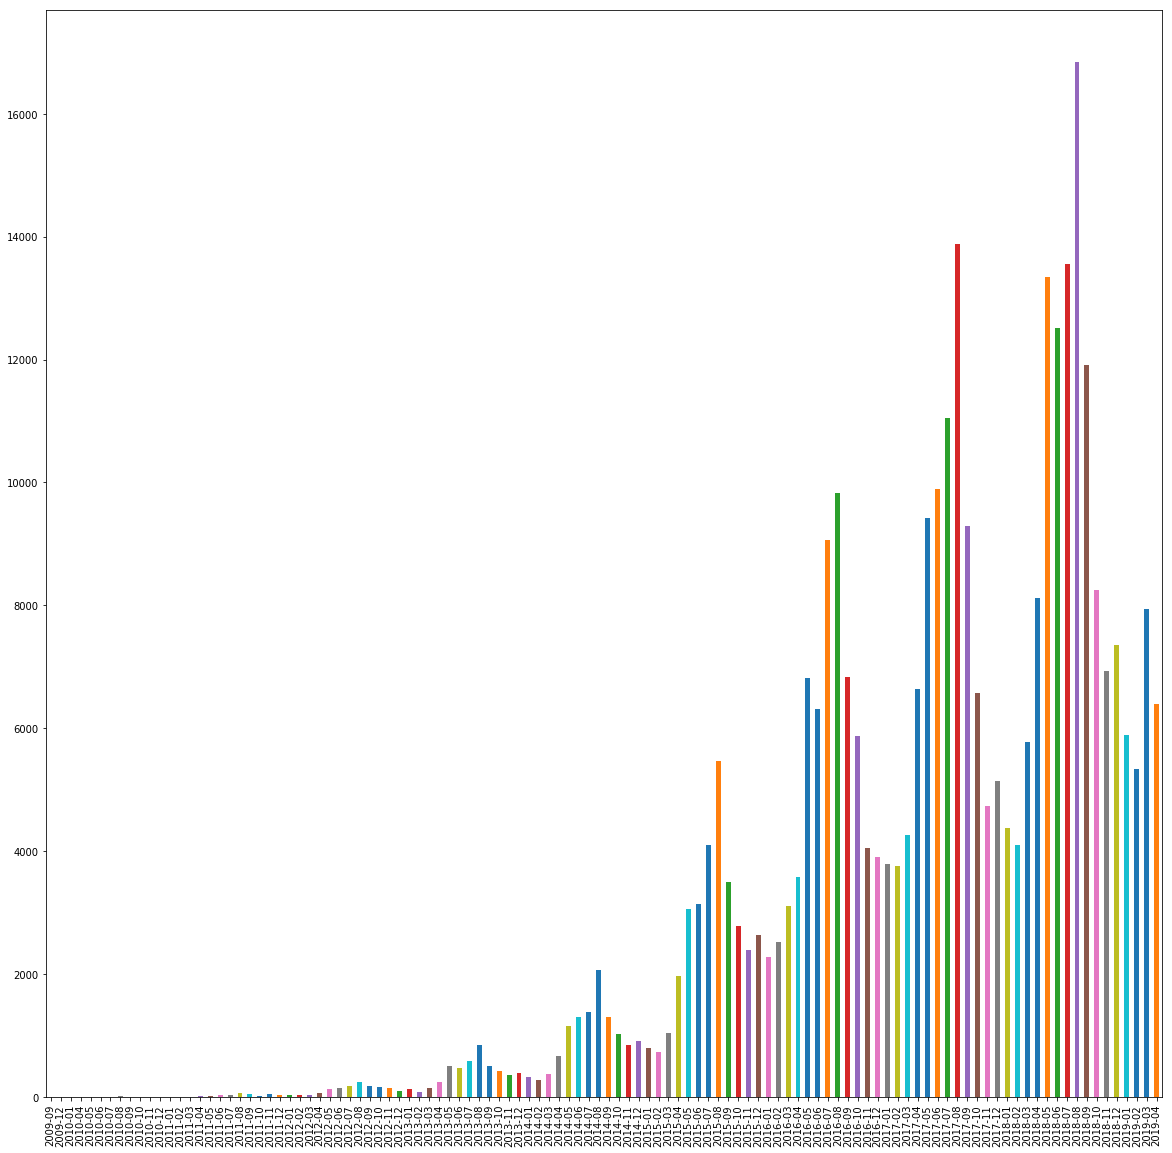

In [43]:
reviews = pd.read_csv("reviews.csv")
yearMonths = reviews['date'].apply(lambda x: x[0:7]).value_counts()
df = pd.DataFrame(yearMonths)
y = []
m = []

for i in range (0,df.count()[0]):
    y.append(int(df.index[i][0:4]))
    m.append(int(df.index[i][-2:]))

df['year'] = y
df['month'] = m

df.sort_values(["year","month"]).date.plot.bar(figsize=(20,20))

Counting reviews per month and inserting every month into a bar chart, sorted chronologically, we can see the development of reviews.

There is a pattern of peaks and valleys that repeats itself - this is the yearly season. January-March are valleys as low-season, and especially August peaks as high season.

We also see that each year, both peaks and valleys increase compared to the previous year; This is THE chart for Airbnb's development in Copenhagen.

To see the seasons in details, we can isolate each year and look at the monthly distribution of reviews.

In [44]:
def isolateYear(year):
    month = []
    count = []
    for i in range(0, yearMonths.count()):
        if (int(yearMonths.index[i][0:4]) == year):
            month.append(int(yearMonths.index[i][-2:]))
            count.append(yearMonths[i])
    return pd.Series(count, index=month).sort_index()

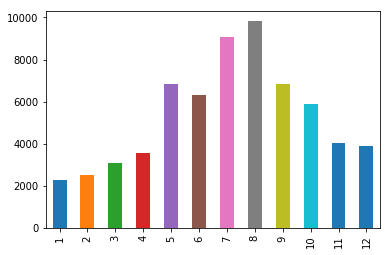

In [47]:
isolateYear(2016).plot.bar()

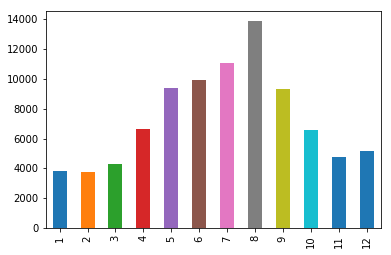

In [46]:
isolateYear(2017).plot.bar()

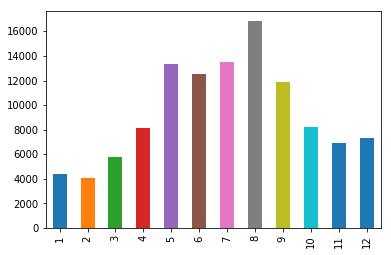

In [45]:
isolateYear(2018).plot.bar()

We can see that the distribution is similar each year, but the numbers increase each year too. The distributions do give you a good sense of which months are high season and which months are low season.

## 4. Genre

something something

## 5. Visualizations

The first interesting visualization is the scatter plot *Price x reviews per month / Price x number of reviews*. We failed to find earnings for listings, but we managed to find listings that are earning well. While a bit difficult to explain, the intuition is that each outlier has a healthy mix of good pricing, frequent reviews and longevity on the platform, and thus they succeed on Airbnb.

The second interesting visualization is the distribution of availability. It is simple, yet has unfortunate implications.

The distribution of reviews per year shows the growth of Airbnb throughout the years. Because our data set does include the entirety of January 2019, we used the distribution of January reviews to see that 2019 will be another growth year for Airbnb. Finally, the distribution of reviews per month over the entire span of the data showed not only the growth of Airbnb, but also the seasons.

## 6. Discussion

Biggest issue is that we never found those earnings, we didn't investigate what high availability meant in practice.

## 7. Contributions

* Gergely did data set acquisition and explored the hotel data set.
* Atchapero did the exploratory analysis.
* Michael did observable visualizations and structured the Observable.